In [1]:
import numpy as np
import matplotlib.pyplot as plt
from regress_lm import core
from regress_lm import rlm

# Set random seed for reproducibility
np.random.seed(42)

print("Successfully imported RegressLM!")
print(f"Available core classes: {[name for name in dir(core) if not name.startswith('_')]}")


Successfully imported RegressLM!
Available core classes: ['Example', 'ExampleInput', 'dataclasses']


In [ ]:
# Create a simple model for quick experimentation
print("Creating RegressLM model...")
reg_lm = rlm.RegressLM.from_default(
    max_input_len=128,
    d_model=64,        # Small model for fast training
    nhead=4,
    num_encoder_layers=1,
    num_decoder_layers=1,
    dim_feedforward=256,
    dropout=0.1,
)

# Create simple training examples (sentiment -> score)
examples = [
    core.Example(x="This is amazing!", y=0.9),
    core.Example(x="Pretty good", y=0.7),
    core.Example(x="Okay I guess", y=0.5),
    core.Example(x="Not great", y=0.3),
    core.Example(x="Terrible", y=0.1),
]

print(f"Created {len(examples)} training examples")
for ex in examples:
    print(f"  '{ex.x}' -> {ex.y}")

# Quick fine-tuning with all available parameters
print("\nFine-tuning model (this may take a minute)...")
reg_lm.fine_tune(
    examples=examples,
    validation_examples=examples,  # Using same data for validation (demo only)
    max_epochs=10,                 # Number of training epochs  
    batch_size=None,               # Use all examples in batch (default)
    seed=42,                       # For reproducible results
)

# Test predictions
test_inputs = [
    core.ExampleInput(x="Fantastic!"),
    core.ExampleInput(x="Bad movie"),
]

print("\nMaking predictions...")
samples = reg_lm.sample(test_inputs, num_samples=5)

for i, inp in enumerate(test_inputs):
    mean_pred = np.mean(samples[i])
    print(f"'{inp.x}' -> {mean_pred:.3f} (samples: {[f'{x:.3f}' for x in samples[i]]})")

print("\n🎉 Basic experiment completed successfully!")


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from regress_lm import core, rlm

# Load the dataset
print("Loading loan default dataset...")
df = pd.read_csv('data/kaggle_loan_default_prediction_dataset/Loan_default_250702_training.csv')

print(f"Dataset shape: {df.shape}")
print(f"Default rate: {df['Default'].mean():.3f}")
print("\nFirst few rows:")
print(df.head())

print("\nColumn info:")
print(df.info())

print("\nTarget distribution:")
print(df['Default'].value_counts())
print(f"Non-default: {(df['Default'] == 0).sum()}")
print(f"Default: {(df['Default'] == 1).sum()}")

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic statistics for numeric columns:")
numeric_cols = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 
                'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
print(df[numeric_cols].describe())


Loading loan default dataset...
Dataset shape: (229769, 18)
Default rate: 0.116

First few rows:
       LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
0  HPSK72WA7R   69   50432      124440          458              15   
1  C1OZ6DPJ8Y   46   84208      129188          451              26   
2  V2KKSFM3UN   32   31713       44799          743               0   
3  EY08JDHTZP   60   20437        9139          633               8   
4  A9S62RQ7US   25   90298       90448          720              18   

   NumCreditLines  InterestRate  LoanTerm  DTIRatio    Education  \
0               1          4.81        60      0.68     Master's   
1               3         21.17        24      0.31     Master's   
2               3          7.07        24      0.23  High School   
3               4          6.51        48      0.73   Bachelor's   
4               2         22.72        24      0.10  High School   

  EmploymentType MaritalStatus HasMortgage HasDependents LoanPurpos

In [3]:
def loan_to_text(row):
    """Convert a loan record to a natural language description."""
    
    # Format currency values
    income = f"${row['Income']:,}"
    loan_amount = f"${row['LoanAmount']:,}"
    
    # Create a comprehensive description
    text = f"""
    A {row['Age']}-year-old {row['MaritalStatus'].lower()} borrower with {row['Education'].lower()} education 
    works {row['EmploymentType'].lower()} and has been employed for {row['MonthsEmployed']} months. 
    They earn {income} annually and are applying for a {loan_amount} loan for {row['LoanPurpose'].lower()} purposes.
    
    Financial profile: Credit score of {row['CreditScore']}, debt-to-income ratio of {row['DTIRatio']:.2f}, 
    and {row['NumCreditLines']} credit lines. The loan terms are {row['LoanTerm']} months at {row['InterestRate']:.2f}% interest rate.
    
    Additional details: {'Has' if row['HasMortgage'] == 'Yes' else 'Does not have'} a mortgage, 
    {'has' if row['HasDependents'] == 'Yes' else 'does not have'} dependents, and 
    {'has' if row['HasCoSigner'] == 'Yes' else 'does not have'} a co-signer.
    """.strip().replace('\n    ', ' ').replace('\n', ' ')
    
    return text

# Test the function with a few examples
print("Sample text descriptions:")
for i in range(3):
    text = loan_to_text(df.iloc[i])
    target = df.iloc[i]['Default']
    print(f"\nExample {i+1} (Default = {target}):")
    print(text)
    print("-" * 80)


Sample text descriptions:

Example 1 (Default = 0):
A 69-year-old married borrower with master's education  works full-time and has been employed for 15 months.  They earn $50,432 annually and are applying for a $124,440 loan for other purposes.  Financial profile: Credit score of 458, debt-to-income ratio of 0.68,  and 1 credit lines. The loan terms are 60 months at 4.81% interest rate.  Additional details: Does not have a mortgage,  does not have dependents, and  has a co-signer.
--------------------------------------------------------------------------------

Example 2 (Default = 1):
A 46-year-old divorced borrower with master's education  works unemployed and has been employed for 26 months.  They earn $84,208 annually and are applying for a $129,188 loan for auto purposes.  Financial profile: Credit score of 451, debt-to-income ratio of 0.31,  and 3 credit lines. The loan terms are 24 months at 21.17% interest rate.  Additional details: Has a mortgage,  has dependents, and  does n

In [4]:
# Sample data for initial experimentation
# Start with 5000 samples for faster training - you can increase this later
SAMPLE_SIZE = 5000
print(f"Sampling {SAMPLE_SIZE} records for training...")

# Stratified sampling to maintain the default rate using train_test_split
# We'll use train_test_split to get our sample, then split again for train/val
sample_df, _ = train_test_split(
    df, 
    train_size=SAMPLE_SIZE, 
    random_state=42, 
    stratify=df['Default']
)

print(f"Sample default rate: {sample_df['Default'].mean():.3f}")
print(f"Sample distribution: {sample_df['Default'].value_counts().to_dict()}")

# Split into train/validation sets
train_df, val_df = train_test_split(
    sample_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=sample_df['Default']
)

print(f"\nTraining set: {len(train_df)} examples")
print(f"Validation set: {len(val_df)} examples")

# Convert to RegressLM Examples
print("\nConverting to RegressLM format...")

# Training examples
train_examples = []
for _, row in train_df.iterrows():
    text = loan_to_text(row)
    target = float(row['Default'])  # Convert to float for regression
    train_examples.append(core.Example(x=text, y=target))

# Validation examples  
val_examples = []
for _, row in val_df.iterrows():
    text = loan_to_text(row)
    target = float(row['Default'])
    val_examples.append(core.Example(x=text, y=target))

print(f"Created {len(train_examples)} training examples")
print(f"Created {len(val_examples)} validation examples")

# Show a few examples
print("\nFirst few training examples:")
for i in range(2):
    ex = train_examples[i]
    print(f"\nExample {i+1}:")
    print(f"Text: {ex.x[:200]}...")
    print(f"Target: {ex.y}")


Sampling 5000 records for training...
Sample default rate: 0.116
Sample distribution: {0: 4421, 1: 579}

Training set: 4000 examples
Validation set: 1000 examples

Converting to RegressLM format...
Created 4000 training examples
Created 1000 validation examples

First few training examples:

Example 1:
Text: A 56-year-old married borrower with high school education  works self-employed and has been employed for 21 months.  They earn $47,066 annually and are applying for a $38,739 loan for other purposes. ...
Target: 0.0

Example 2:
Text: A 69-year-old single borrower with high school education  works full-time and has been employed for 57 months.  They earn $93,192 annually and are applying for a $54,236 loan for education purposes.  ...
Target: 0.0


Creating PyTorchModel for loan default prediction...
Model and optimizer created successfully!
Model type: <class 'regress_lm.models.pytorch.model.PyTorchModel'>
Optimizer type: <class 'torch.optim.Adafactor'>
Converting examples to tensor format...
Training tensor shapes:
  encoder_input: torch.Size([4000, 512])
  decoder_input: torch.Size([4000, 7])
  decoder_target: torch.Size([4000, 7])

STARTING TRAINING (Lower-level approach)
Following the approach recommended in the README...
This gives us more control over the training process.

Training for 30 epochs with batch size 32
Total batches per epoch: 125
------------------------------------------------------------
Epoch  1/30 | Train Loss: 1.7132 | Val Loss: 0.5898 | Time: 405.9s
Epoch  6/30 | Train Loss: 0.1067 | Val Loss: 0.0830 | Time: 420.7s
Epoch 11/30 | Train Loss: 0.0779 | Val Loss: 0.0730 | Time: 409.5s
Epoch 16/30 | Train Loss: 0.0727 | Val Loss: 0.0717 | Time: 398.5s
Epoch 21/30 | Train Loss: 0.0700 | Val Loss: 0.0704 | Tim

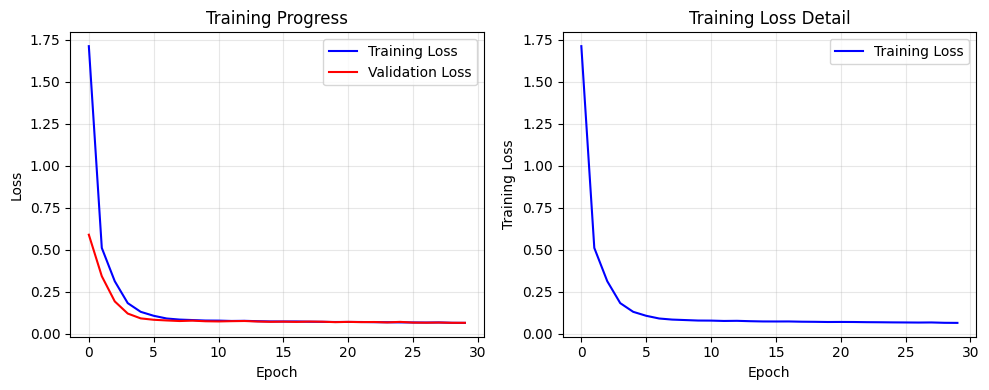

In [5]:
# Create RegressLM model using lower-level approach (as recommended in README)
print("Creating PyTorchModel for loan default prediction...")

from torch import optim
from regress_lm.models.pytorch import model as torch_model_lib
from regress_lm import vocabs, tokenizers

# Create model components manually for better control
encoder_vocab = vocabs.SentencePieceVocab.from_t5()
decoder_vocab = vocabs.DecoderVocab(tokenizers.P10Tokenizer())

# Create the PyTorchModel directly (following README approach)
model = torch_model_lib.PyTorchModel(
    encoder_vocab=encoder_vocab,
    decoder_vocab=decoder_vocab,
    max_input_len=512,           # Max length for loan descriptions
    learning_rate=5e-5,          # This is stored but we'll use our own optimizer
    d_model=256,                 # Model dimension
    nhead=8,                     # Number of attention heads
    num_encoder_layers=3,        # Number of encoder layers
    num_decoder_layers=3,        # Number of decoder layers  
    dim_feedforward=1024,        # Feedforward dimension
    dropout=0.1,                 # Dropout for regularization
    z_loss_coef=1e-4,           # Additional regularization
)

# Create optimizer as recommended in README
optimizer = optim.Adafactor(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-4
)

print("Model and optimizer created successfully!")
print(f"Model type: {type(model)}")
print(f"Optimizer type: {type(optimizer)}")

# Convert examples to tensor format
print("Converting examples to tensor format...")
train_tensor_examples = model.convert_examples(train_examples)
val_tensor_examples = model.convert_examples(val_examples)

print(f"Training tensor shapes:")
for key, tensor in train_tensor_examples.items():
    print(f"  {key}: {tensor.shape}")

# Training loop following README approach
print("\n" + "="*60)
print("STARTING TRAINING (Lower-level approach)")
print("="*60)
print("Following the approach recommended in the README...")
print("This gives us more control over the training process.\n")

import torch
import time

num_epochs = 30
batch_size = 32
num_examples = len(train_examples)
num_batches = (num_examples + batch_size - 1) // batch_size

train_losses = []
val_losses = []

print(f"Training for {num_epochs} epochs with batch size {batch_size}")
print(f"Total batches per epoch: {num_batches}")
print("-" * 60)

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    epoch_losses = []
    
    # Shuffle training data
    indices = torch.randperm(num_examples)
    
    for batch_idx in range(num_batches):
        # Get batch indices
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_examples)
        batch_indices = indices[start_idx:end_idx]
        
        # Create batch
        batch_examples = {
            key: tensor[batch_indices] for key, tensor in train_tensor_examples.items()
        }
        
        # Training step (following README pattern)
        optimizer.zero_grad()
        loss, metrics = model.compute_loss_and_metrics(batch_examples)
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_loss, val_metrics = model.compute_loss_and_metrics(val_tensor_examples)
    
    # Record losses
    avg_train_loss = sum(epoch_losses) / len(epoch_losses)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss.item())
    
    # Print progress
    epoch_time = time.time() - epoch_start
    if epoch % 5 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1:2d}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {val_loss.item():.4f} | "
              f"Time: {epoch_time:.1f}s")

total_time = time.time() - start_time
print("\n" + "="*60)
print("TRAINING COMPLETED!")
print("="*60)
print(f"Total training time: {total_time:.1f} seconds")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")

# Plot training curves
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Detail')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Store the model in a RegressLM wrapper for easy prediction
loan_model = rlm.RegressLM(model, torch_model_lib.PyTorchFineTuner(model))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

print("Evaluating the trained model...")

# Make predictions on validation set
val_inputs = [core.ExampleInput(x=ex.x) for ex in val_examples]
val_targets = [ex.y for ex in val_examples]

print(f"Making predictions on {len(val_inputs)} validation examples...")

# Generate multiple samples for uncertainty estimation
num_samples = 10
predictions = loan_model.sample(val_inputs, num_samples=num_samples)

# Calculate mean predictions and uncertainties
mean_predictions = [np.mean(pred) for pred in predictions]
std_predictions = [np.std(pred) for pred in predictions]

print("Predictions completed!")

# Convert predictions to binary classification (threshold at 0.5)
binary_predictions = [1 if pred >= 0.5 else 0 for pred in mean_predictions]

# Calculate classification metrics
accuracy = accuracy_score(val_targets, binary_predictions)
precision = precision_score(val_targets, binary_predictions)
recall = recall_score(val_targets, binary_predictions)
f1 = f1_score(val_targets, binary_predictions)
auc = roc_auc_score(val_targets, mean_predictions)

print("\n" + "="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

print(f"\nMean prediction: {np.mean(mean_predictions):.4f}")
print(f"Mean uncertainty (std): {np.mean(std_predictions):.4f}")

# Confusion Matrix
cm = confusion_matrix(val_targets, binary_predictions)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                No    Yes")
print(f"Actual No    {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"Actual Yes   {cm[1,0]:4d}  {cm[1,1]:4d}")

# Classification report
print(f"\nDetailed Classification Report:")
print(classification_report(val_targets, binary_predictions, 
                          target_names=['No Default', 'Default']))


Evaluating the trained model...
Making predictions on 1000 validation examples...


In [ ]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Prediction distribution by actual class
axes[0, 0].hist([pred for i, pred in enumerate(mean_predictions) if val_targets[i] == 0], 
                alpha=0.7, label='No Default (Actual)', bins=30, color='blue')
axes[0, 0].hist([pred for i, pred in enumerate(mean_predictions) if val_targets[i] == 1], 
                alpha=0.7, label='Default (Actual)', bins=30, color='red')
axes[0, 0].axvline(x=0.5, color='black', linestyle='--', label='Decision Threshold')
axes[0, 0].set_xlabel('Predicted Default Probability')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of Predictions by Actual Class')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Uncertainty vs prediction
scatter = axes[0, 1].scatter(mean_predictions, std_predictions, 
                            c=val_targets, cmap='RdYlBu', alpha=0.6)
axes[0, 1].set_xlabel('Mean Prediction')
axes[0, 1].set_ylabel('Prediction Uncertainty (Std)')
axes[0, 1].set_title('Prediction Uncertainty vs Mean Prediction')
plt.colorbar(scatter, ax=axes[0, 1], label='Actual Default')
axes[0, 1].grid(True, alpha=0.3)

# 3. Confusion matrix heatmap
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
axes[1, 0].set_title('Confusion Matrix')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# 4. ROC-like curve (prediction vs actual)
sorted_indices = np.argsort(mean_predictions)
sorted_predictions = np.array(mean_predictions)[sorted_indices]
sorted_targets = np.array(val_targets)[sorted_indices]

# Calculate cumulative metrics
cumulative_positives = np.cumsum(sorted_targets)
total_positives = cumulative_positives[-1]
cumulative_recall = cumulative_positives / total_positives if total_positives > 0 else np.zeros_like(cumulative_positives)

axes[1, 1].plot(sorted_predictions, cumulative_recall, 'b-', linewidth=2)
axes[1, 1].set_xlabel('Prediction Threshold')
axes[1, 1].set_ylabel('Cumulative Recall')
axes[1, 1].set_title('Cumulative Recall vs Prediction Threshold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Show some example predictions
print("\n" + "="*80)
print("EXAMPLE PREDICTIONS")
print("="*80)

# Show predictions for both classes
default_indices = [i for i, target in enumerate(val_targets) if target == 1]
no_default_indices = [i for i, target in enumerate(val_targets) if target == 0]

print("\nExamples of DEFAULT loans (actual = 1):")
for i in default_indices[:3]:
    ex = val_examples[i]
    pred = mean_predictions[i]
    uncertainty = std_predictions[i]
    print(f"\nPrediction: {pred:.3f} ± {uncertainty:.3f}")
    print(f"Text: {ex.x[:300]}...")
    print("-" * 40)

print("\nExamples of NON-DEFAULT loans (actual = 0):")
for i in no_default_indices[:3]:
    ex = val_examples[i]
    pred = mean_predictions[i]
    uncertainty = std_predictions[i]
    print(f"\nPrediction: {pred:.3f} ± {uncertainty:.3f}")
    print(f"Text: {ex.x[:300]}...")
    print("-" * 40)


In [ ]:
# Function to make predictions on new loan applications
def predict_loan_default(loan_model, loan_record, num_samples=20):
    """
    Make a prediction on a single loan application.
    
    Args:
        loan_model: Trained RegressLM model
        loan_record: Dictionary or pandas Series with loan application data
        num_samples: Number of samples for uncertainty estimation
    
    Returns:
        dict: Prediction results including mean, std, and risk assessment
    """
    # Convert to pandas Series if it's a dictionary
    if isinstance(loan_record, dict):
        loan_record = pd.Series(loan_record)
    
    # Convert to text description
    text_description = loan_to_text(loan_record)
    
    # Create input for the model
    model_input = [core.ExampleInput(x=text_description)]
    
    # Get prediction with uncertainty
    prediction_samples = loan_model.sample(model_input, num_samples=num_samples)
    mean_pred = np.mean(prediction_samples[0])
    std_pred = np.std(prediction_samples[0])
    
    # Determine risk level
    if mean_pred < 0.3:
        risk_level = "LOW RISK"
        recommendation = "✅ APPROVE - Low default risk"
    elif mean_pred < 0.5:
        risk_level = "MEDIUM RISK"
        recommendation = "⚠️  REVIEW - Moderate risk, consider additional conditions"
    elif mean_pred < 0.7:
        risk_level = "HIGH RISK"
        recommendation = "⚠️  CAUTION - High risk, require additional security/co-signer"
    else:
        risk_level = "VERY HIGH RISK"
        recommendation = "❌ DENY - Very high default risk"
    
    return {
        'default_probability': mean_pred,
        'uncertainty': std_pred,
        'risk_level': risk_level,
        'recommendation': recommendation,
        'confidence': 'High' if std_pred < 0.2 else 'Medium' if std_pred < 0.4 else 'Low',
        'all_samples': prediction_samples[0]
    }

# Example usage with your evaluation dataset:
"""
# Load your evaluation dataset
eval_df = pd.read_csv('data/kaggle_loan_default_prediction_dataset/Loan_default_250702_evaluation.csv')

# Make predictions on the evaluation set
eval_predictions = []
for _, row in eval_df.iterrows():
    result = predict_loan_default(loan_model, row)
    eval_predictions.append(result)

# Analyze results
eval_probs = [pred['default_probability'] for pred in eval_predictions]
eval_uncertainties = [pred['uncertainty'] for pred in eval_predictions]

print(f"Evaluation set predictions:")
print(f"Mean default probability: {np.mean(eval_probs):.3f}")
print(f"Mean uncertainty: {np.mean(eval_uncertainties):.3f}")

# If you have ground truth labels, calculate metrics:
if 'Default' in eval_df.columns:
    true_labels = eval_df['Default'].values
    predicted_labels = [1 if p >= 0.5 else 0 for p in eval_probs]
    
    from sklearn.metrics import accuracy_score, classification_report
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"\\nEvaluation Accuracy: {accuracy:.4f}")
    print("\\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))
"""

print("🎯 LOAN DEFAULT PREDICTION MODEL - READY FOR EVALUATION!")
print("="*80)
print("Your RegressLM model is now trained and ready to evaluate loan applications.")
print("Use the predict_loan_default() function to make predictions on your evaluation dataset.")
print("Uncomment and modify the example code above to evaluate on your reserved test set.")


In [ ]:
# Load your evaluation dataset
print("Loading evaluation dataset...")
eval_df = pd.read_csv('data/kaggle_loan_default_prediction_dataset/Loan_default_250702_evaluation.csv')

print(f"Evaluation dataset shape: {eval_df.shape}")
print(f"Evaluation default rate: {eval_df['Default'].mean():.3f}")

# Make predictions on the evaluation set
print(f"\nMaking predictions on {len(eval_df)} evaluation examples...")
print("This may take several minutes depending on the dataset size...")

eval_predictions = []
eval_probabilities = []
eval_uncertainties = []

# Process in batches to show progress
batch_size = 100
for i in range(0, len(eval_df), batch_size):
    batch_end = min(i + batch_size, len(eval_df))
    print(f"Processing batch {i//batch_size + 1}/{(len(eval_df)-1)//batch_size + 1} "
          f"(rows {i+1}-{batch_end})...")
    
    for _, row in eval_df.iloc[i:batch_end].iterrows():
        result = predict_loan_default(loan_model, row, num_samples=10)
        eval_predictions.append(result)
        eval_probabilities.append(result['default_probability'])
        eval_uncertainties.append(result['uncertainty'])

print("Predictions completed!")

# Convert to binary predictions using 0.5 threshold
eval_binary_preds = [1 if p >= 0.5 else 0 for p in eval_probabilities]
eval_true_labels = eval_df['Default'].values

# Calculate comprehensive metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report
)

accuracy = accuracy_score(eval_true_labels, eval_binary_preds)
precision = precision_score(eval_true_labels, eval_binary_preds)
recall = recall_score(eval_true_labels, eval_binary_preds)
f1 = f1_score(eval_true_labels, eval_binary_preds)
auc = roc_auc_score(eval_true_labels, eval_probabilities)

print("\n" + "="*60)
print("FINAL EVALUATION RESULTS ON TEST SET")
print("="*60)
print(f"Dataset Size: {len(eval_df):,} examples")
print(f"Actual Default Rate: {eval_df['Default'].mean():.3f}")
print(f"Predicted Default Rate: {np.mean(eval_binary_preds):.3f}")
print()
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")
print()
print(f"Mean Prediction: {np.mean(eval_probabilities):.4f}")
print(f"Mean Uncertainty: {np.mean(eval_uncertainties):.4f}")

# Confusion Matrix
cm = confusion_matrix(eval_true_labels, eval_binary_preds)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                No    Yes")
print(f"Actual No    {cm[0,0]:6d}  {cm[0,1]:6d}")
print(f"Actual Yes   {cm[1,0]:6d}  {cm[1,1]:6d}")

# Risk level distribution
risk_levels = [pred['risk_level'] for pred in eval_predictions]
risk_counts = pd.Series(risk_levels).value_counts()
print(f"\nRisk Level Distribution:")
for risk, count in risk_counts.items():
    percentage = (count / len(risk_levels)) * 100
    print(f"{risk}: {count:,} ({percentage:.1f}%)")

print(f"\nDetailed Classification Report:")
print(classification_report(eval_true_labels, eval_binary_preds, 
                          target_names=['No Default', 'Default']))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from regress_lm import core
from regress_lm import rlm

# Set random seed for reproducibility
np.random.seed(42)

print("Successfully imported RegressLM!")
print(f"Available core classes: {[name for name in dir(core) if not name.startswith('_')]}")


In [ ]:
# Create a RegressLM with default settings
# You can customize parameters like max_input_len, learning_rate, model size, etc.
reg_lm = rlm.RegressLM.from_default(
    max_input_len=512,          # Maximum length of input text
    learning_rate=1e-4,         # Learning rate for fine-tuning
    d_model=256,                # Model dimension (smaller for faster experiments)
    nhead=4,                    # Number of attention heads
    num_encoder_layers=2,       # Number of encoder layers
    num_decoder_layers=2,       # Number of decoder layers
    dim_feedforward=1024,       # Feedforward dimension
    dropout=0.1,                # Dropout rate for regularization
)

print("RegressLM model created successfully!")
print(f"Model type: {type(reg_lm.model)}")
print(f"Fine-tuner type: {type(reg_lm.fine_tuner)}")


In [ ]:
# Example 1: Sentiment to score mapping
sentiment_examples = [
    core.Example(x="This movie is absolutely fantastic!", y=0.9),
    core.Example(x="I loved every minute of it", y=0.8),
    core.Example(x="Pretty good movie overall", y=0.6),
    core.Example(x="It was okay, nothing special", y=0.3),
    core.Example(x="I didn't like it very much", y=0.1),
    core.Example(x="Terrible movie, waste of time", y=0.0),
]

# Example 2: Simple numerical relationships
number_examples = [
    core.Example(x="The number five", y=5.0),
    core.Example(x="ten plus ten", y=20.0),
    core.Example(x="three times four", y=12.0),
    core.Example(x="half of sixteen", y=8.0),
    core.Example(x="seven squared", y=49.0),
]

print(f"Created {len(sentiment_examples)} sentiment examples")
print(f"Created {len(number_examples)} numerical examples")

# Display some examples
print("\nSample sentiment examples:")
for ex in sentiment_examples[:3]:
    print(f"  Text: '{ex.x}' -> Score: {ex.y}")


In [ ]:
# Fine-tune on sentiment examples
print("Fine-tuning on sentiment examples...")
reg_lm.fine_tune(
    examples=sentiment_examples,
    validation_examples=sentiment_examples,  # Using same data for validation (just for demo)
    max_epochs=50,  # Reduce epochs for faster training
    batch_size=None,  # Use all examples in each batch
)
print("Fine-tuning completed!")


In [ ]:
# Test inputs
test_inputs = [
    core.ExampleInput(x="This is an amazing film!"),
    core.ExampleInput(x="I hate this movie"),
    core.ExampleInput(x="The movie was decent"),
    core.ExampleInput(x="Best movie ever made"),
    core.ExampleInput(x="Boring and pointless"),
]

# Generate predictions (multiple samples for uncertainty estimation)
num_samples = 10
print(f"Generating {num_samples} samples for each input...")

samples = reg_lm.sample(test_inputs, num_samples=num_samples)

# Display results
print("\nPrediction Results:")
print("=" * 60)

for i, test_input in enumerate(test_inputs):
    sample_values = samples[i]
    mean_pred = np.mean(sample_values)
    std_pred = np.std(sample_values)
    
    print(f"Text: '{test_input.x}'")
    print(f"  Mean prediction: {mean_pred:.3f} ± {std_pred:.3f}")
    print(f"  Sample range: [{np.min(sample_values):.3f}, {np.max(sample_values):.3f}]")
    print(f"  All samples: {[f'{x:.3f}' for x in sample_values]}")
    print()


In [ ]:
# Create a visualization of the predictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Mean predictions with error bars
test_texts = [inp.x for inp in test_inputs]
means = [np.mean(samples[i]) for i in range(len(test_inputs))]
stds = [np.std(samples[i]) for i in range(len(test_inputs))]

ax1.errorbar(range(len(test_texts)), means, yerr=stds, 
             marker='o', capsize=5, capthick=2, markersize=8)
ax1.set_xticks(range(len(test_texts)))
ax1.set_xticklabels([text[:20] + '...' if len(text) > 20 else text 
                     for text in test_texts], rotation=45, ha='right')
ax1.set_ylabel('Predicted Score')
ax1.set_title('Sentiment Predictions with Uncertainty')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-0.1, 1.1)

# Plot 2: Distribution of all samples
sample_data = [samples[i] for i in range(len(test_inputs))]
ax2.boxplot(sample_data, labels=[f'T{i+1}' for i in range(len(test_inputs))])
ax2.set_ylabel('Predicted Score')
ax2.set_xlabel('Test Input')
ax2.set_title('Distribution of Predictions')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics:")
print(f"Overall mean prediction: {np.mean([np.mean(samples[i]) for i in range(len(test_inputs))]):.3f}")
print(f"Overall std of means: {np.std([np.mean(samples[i]) for i in range(len(test_inputs))]):.3f}")
print(f"Average uncertainty (std): {np.mean([np.std(samples[i]) for i in range(len(test_inputs))]):.3f}")


In [ ]:
experiment_ideas = [
    "1. Domain-specific regression: Train on scientific data (e.g., chemical properties from descriptions)",
    "2. Time series prediction: Use text descriptions of events to predict future values",
    "3. Multi-output regression: Modify the model to predict multiple values simultaneously",
    "4. Active learning: Implement uncertainty-based sample selection for training",
    "5. Evaluation metrics: Implement proper train/validation/test splits and evaluation",
    "6. Data augmentation: Generate synthetic examples through text paraphrasing",
    "7. Interpretability: Analyze attention weights to understand model decisions",
    "8. Transfer learning: Use pre-trained language models as encoders",
    "9. Robustness testing: Evaluate model performance on adversarial or noisy inputs",
    "10. Real-world application: Apply to actual business/research problems"
]

print("💡 Experiment Ideas for Further Exploration:")
print("=" * 50)
for idea in experiment_ideas:
    print(f"   {idea}")

print("\n🚀 Ready to start experimenting!")
print("\nUseful next steps:")
print("- Modify the examples above with your own data")
print("- Experiment with different model architectures")
print("- Try different fine-tuning strategies")
print("- Implement proper evaluation metrics")
print("- Scale up to larger datasets")
